## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [41]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [42]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

tf.config.list_physical_devices('GPU') # list the available physical GPU devices TensorFlow can detect on the machine

[]

In [44]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

In [45]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
# samples with a size of 32x32 pixels and 3 color channels (RGB)
print(x_train.shape[0], 'train samples') # 50,000 train samples
print(x_test.shape[0], 'test samples') # 10,000 test samples

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [46]:
## Each image is a 32 x 32 x 3 numpy array
x_train[444].shape, x_train[444].dtype 

((32, 32, 3), dtype('uint8'))

[9] truck


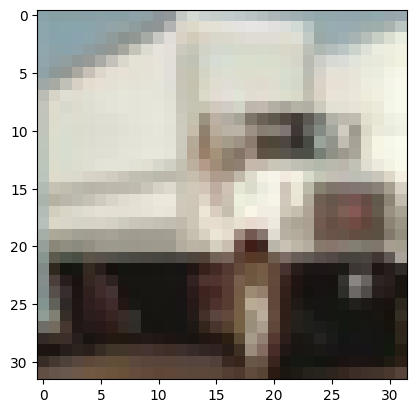

In [47]:
## Let's look at one of the images

image_no = 444
print(y_train[image_no], class_names[y_train[image_no][0]])
plt.imshow(x_train[image_no]);

In [48]:
num_classes = 10
'''
    ### one hot encoding 
    converting categorical labels into a binary matrix representation, 
    where each row corresponds to a sample, and each column corresponds to a class. 
    The column corresponding to the true class for a sample is set to 1, 
    and all other columns are set to 0.
'''
y_train = keras.utils.to_categorical(y_train, num_classes) # one-hot encoding
y_test = keras.utils.to_categorical(y_test, num_classes)

In [53]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [54]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # scale the data to values between 0 and 1
x_test /= 255 # scale the data to values between 0 and 1

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## First CNN
1. Below we will build our first CNN. For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  
2. We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  
3. After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.

In [60]:
set_seed(12345)

# Let's build a CNN using Keras' Sequential capabilities
model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
## padding='same', which pads the input such that the output has the same length as the original input 
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 32)        2432      
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 288)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               147968    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

We still have 181K parameters, even though this is a "small" model.


In [64]:
batch_size = 32

# initiate RMSprop optimizer
# RMSprop, an optimizer that's usually a good choice for recurrent NN
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
# categorical_crossentropy, the loss function used for categorical classification
model_1.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy']) 

history_1 = model_1.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 2.3028 - accuracy: 0.0966 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3028 - accuracy: 0.0970 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3027 - accuracy: 0.0973 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 2.3027 - accuracy: 0.0966 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3027 - accuracy: 0.0969 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 2.3027 - accuracy: 0.0962 - val_loss: 2.3026 - val_accuracy:

In [95]:
print(history_1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [96]:
print("The loss on the test set is: ", model_1.evaluate(x_test, y_test)[0])
for i in range(len(history_1.history['loss'])):
    print("%d, %f\n" % (i+1, history_1.history['loss'][i]), end=' ')
print("\n")

313/313 [==============================] - 0s 1ms/step - loss: 2.3026 - accuracy: 0.1000
The loss on the test set is:  2.302589178085327
1, 2.302820
 2, 2.302774
 3, 2.302709
 4, 2.302693
 5, 2.302679
 6, 2.302672
 7, 2.302745
 8, 2.302701
 9, 2.302709
 10, 2.302712
 



In [97]:
print("The accuracy on the test set is: ", model_1.evaluate(x_test, y_test)[1])
for i in range(len(history_1.history['accuracy'])):
    print("%d, %f\n" % (i+1, history_1.history['accuracy'][i]), end=' ')
print("\n")

313/313 [==============================] - 0s 1ms/step - loss: 2.3026 - accuracy: 0.1000
The accuracy on the test set is:  0.10000000149011612
1, 0.096580
 2, 0.096980
 3, 0.097340
 4, 0.096580
 5, 0.098760
 6, 0.096900
 7, 0.096200
 8, 0.096040
 9, 0.096740
 10, 0.097640
 



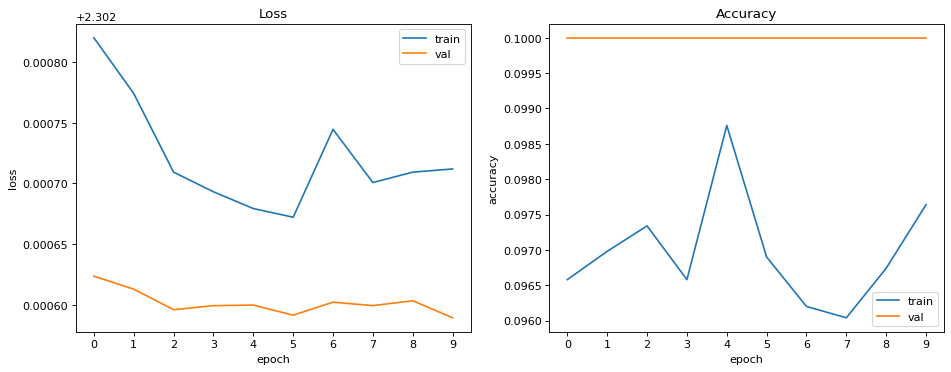

In [65]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

### Model Evaluation

In [66]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_1.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_1.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 2.302591, Accuracy: 0.100000
 Test Loss: 2.302589, Accuracy: 0.100000

[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


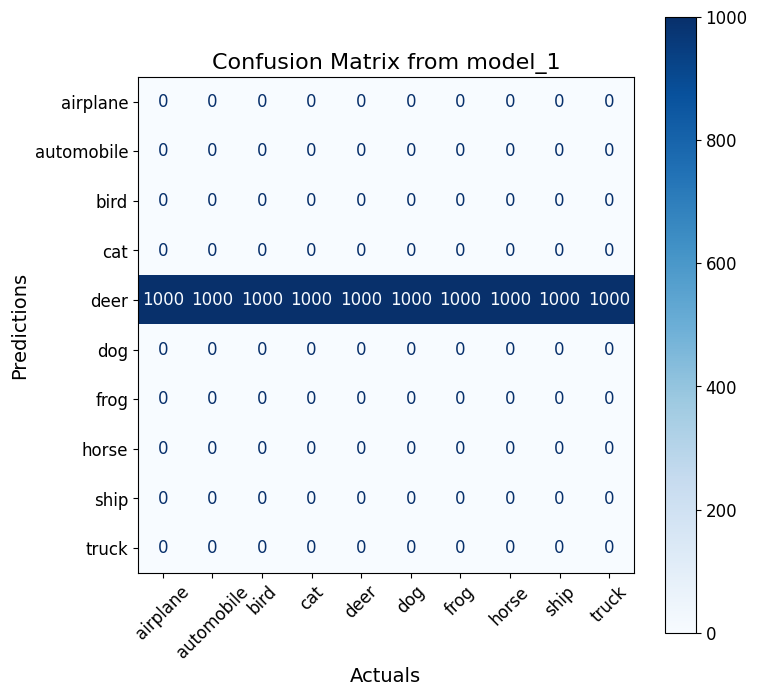

In [67]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [68]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.10      1.00      0.18      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + TN + FP + FN} \\
Precision &= \frac{TP}{TP + FP} \\
Recall &= \frac{TP}{TP + FN} \\
F1-Score &= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{align}
$

where 
$TP$: True Positives, $TN$: True Negatives, $FP$: False Positives, and $FN$: False Negatives


### <span style="color:blue">แบบฝึกปฏิบัติ</span>
จากโครงสร้างของโมเดลเดิม:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. ให้สร้างโมเดลใหม่ที่มีความซับซ้อนมากขึ้นโดยสามารถใช้รูปแบบโครงสร้างดังนี้:
   - Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

   - ให้ใช้ stride เป็น 1 สำหรับทุกเลเยอร์ convolutional.

2. เทรนโมเดลใหม่โดยใช้เพียง 10 epochs (เท่ากับการเทรนโมเดลเดิม) และอธิบายสิ่งที่สังเกตได้ในเรื่องของเวลา และค่า loss และ accuracy ที่วัดได้จากทั้งชุดข้อมูลเทรนและเทส

3. จากผลการทดสอบโมเดลใหม่ด้วยชุดข้อมูลเทส ให้สร้างกราฟ Confusion Matrix และแสดงรายงาน classification report

4. หาภาพที่โมเดลใหม่ทำนายผิดมาอย่างน้อย 1 ภาพ โดยแสดงภาพให้ปรากฏ แสดงข้อความว่าภาพนั้นเป็นภาพของคลาสอะไร และโมเดลทำนายผิดเป็นคลาสอะไร

In [73]:
set_seed(12345)

model_2 = Sequential()

model_2.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', 
                   input_shape=x_train.shape[1:], activation='relu'))
model_2.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (5, 5), strides=(1, 1), 
                   padding='same', activation='relu'))
model_2.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes, activation='softmax'))

model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 64)        51264     
                                                                 
 conv2d_29 (Conv2D)          (None, 10, 10, 64)        102464    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                

In [74]:
batch_size = 32

opt = keras.optimizers.RMSprop(learning_rate=0.0005)

model_2.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_2 = model_2.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_test, y_test),
                        shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 68s 43ms/step - loss: 2.3028 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 66s 42ms/step - loss: 2.3028 - accuracy: 0.0966 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 68s 43ms/step - loss: 2.3027 - accuracy: 0.0984 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 70s 45ms/step - loss: 2.3027 - accuracy: 0.0972 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 69s 44ms/step - loss: 2.3027 - accuracy: 0.0998 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 65s 42ms/step - loss: 2.3027 - accuracy: 0.0963 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 69s 44ms/step - loss: 2.3027 - accuracy: 0.0967 - val_loss: 2.3026 -

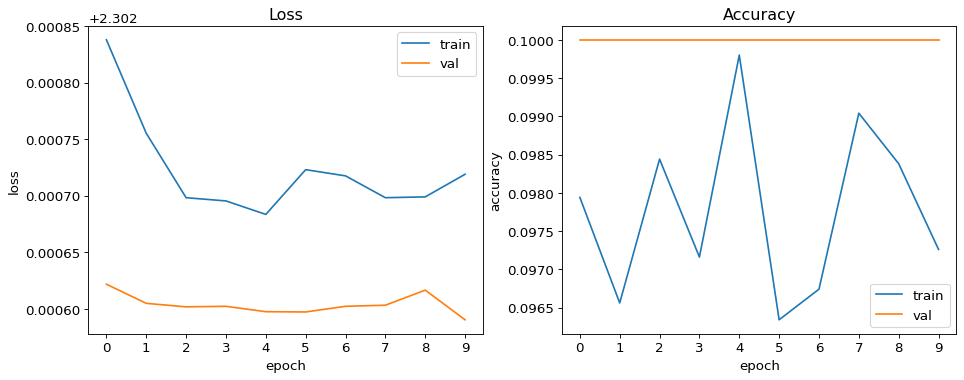

In [76]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_2.history['loss'])
ax.plot(history_2.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_2.history['accuracy'])
ax.plot(history_2.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [79]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model_2.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model_2.predict(x_test, verbose=0)

y_test_2d = np.argmax(y_test, axis=1)
y_pred_2d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_2d, y_pred=y_pred_2d).T
print(cm)

Train Loss: 2.302591, Accuracy: 0.100000
 Test Loss: 2.302590, Accuracy: 0.100000

[[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


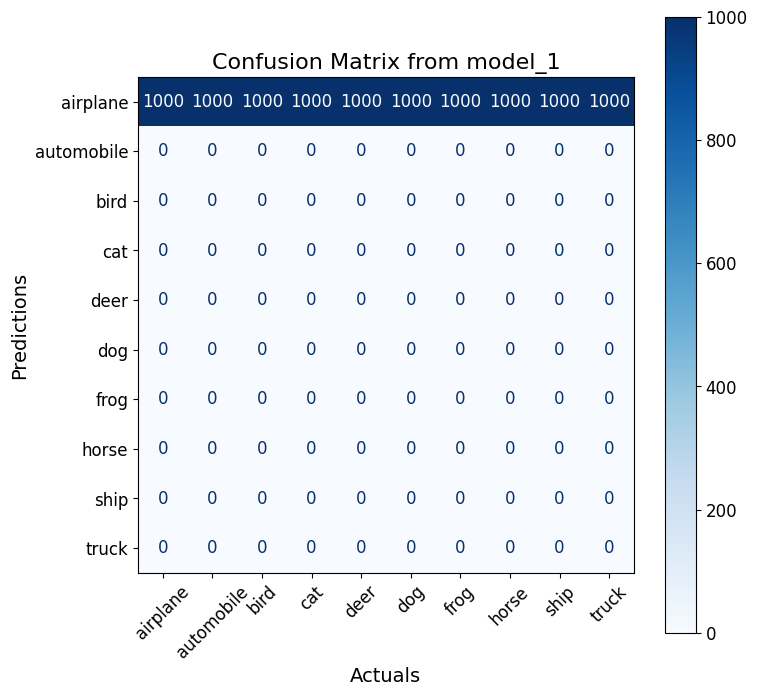

In [80]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [81]:
np.set_printoptions(precision=2)

print(classification_report(y_true=y_test_2d, y_pred=y_pred_2d, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.10      1.00      0.18      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.